In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
#import pygraphviz
import networkx as nx
import math
import numpy as np
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
#syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

In [2]:
real_text_news = []
with open('corpora.txt', 'r', encoding='utf-8') as d:
    data = d.read()
    text_news = data.split('=====\n')
    for t_n in text_news:
        t_n = t_n.split('\n')
        real_text_news.append(t_n[-2])
        doc = Doc(t_n[-2])

        doc.segment(segmenter)
        doc.tag_morph(morph_tagger)
        doc.tag_ner(ner_tagger)
      #  display(doc.spans)
    
    
def get_namtag(text):
    doc = Doc(text)

    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.tag_ner(ner_tagger)
    for s in doc.spans:
        s.normalize(morph_vocab)
    return [(s.normal, s.type) for s in doc.spans]

def getGr(cheb):
    names={}
    connect={}
    for art in tqdm(cheb):
        if len(art)>2:
            nfacts = get_namtag(art)
          #  print(nfacts)
            nam=[fact[0] for fact in nfacts if fact[1]=='PER']
            nam=[fact[0] for fact in nfacts if fact[1]=='ORG']
            snamorg=list(set(nam))
            for n in snamorg:
                names[n]=names.get(n, 0)+1
                pers=connect.get(n, {})
                for n2 in snamorg:
                    if n!=n2:
                        pers[n2]=pers.get(n2, 0)+1
                connect[n]=pers
    return names, connect

names, connections = getGr(real_text_news)

100%|████████████████████████████████████████████████████████████████████████████| 21389/21389 [37:02<00:00,  9.63it/s]


In [27]:
pers2={n:{n2:connections[n][n2] for n2 in connections[n].keys() if names[n2]>64}
           for n in connections.keys() if names[n]>64}

In [28]:
def formASocialGraph(persons):
    G=nx.Graph()
    for n in persons.keys():
        for n2 in persons[n].keys():
            G.add_edge(n, n2)
    return G


G1=formASocialGraph(pers2)

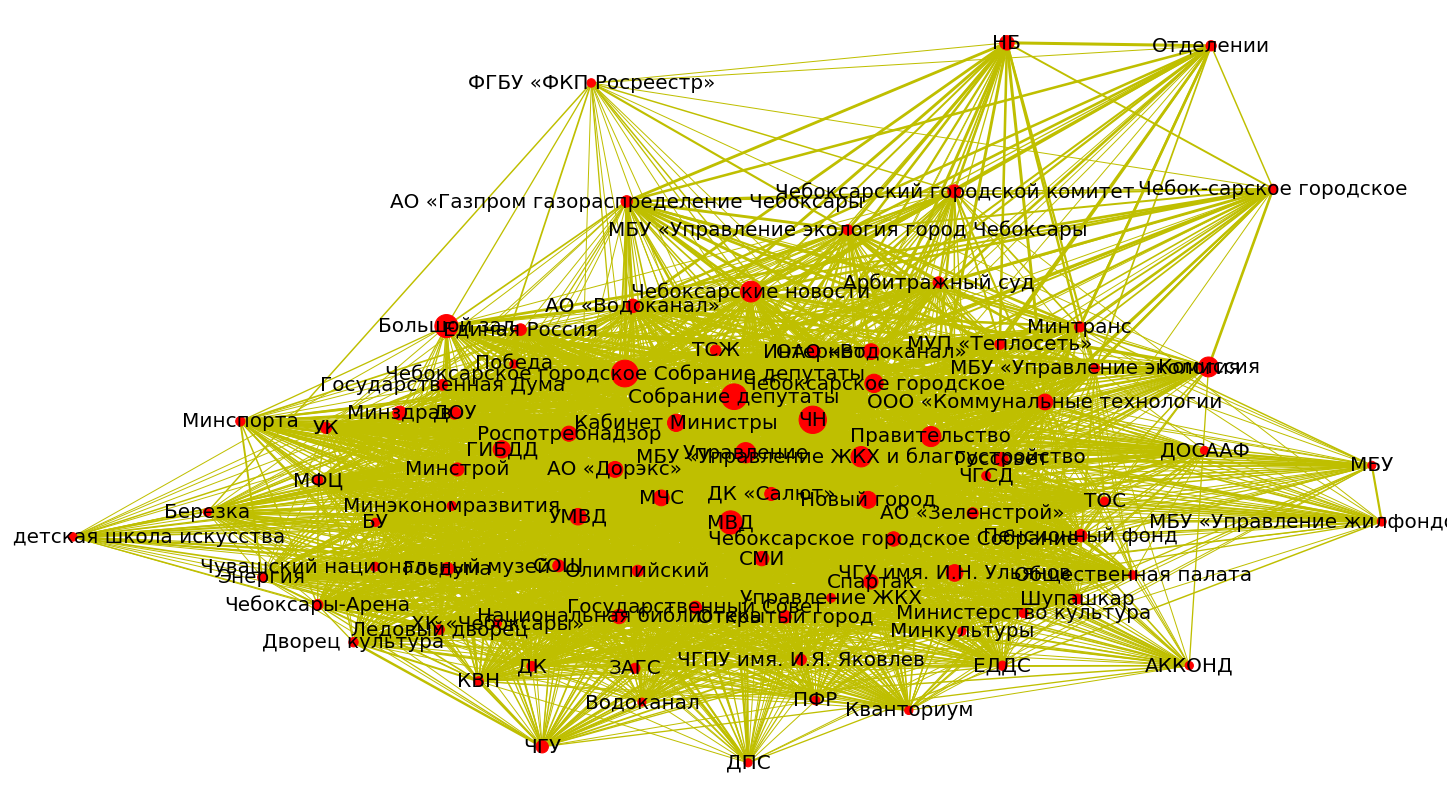

In [33]:
def drawASocialGraph(G, persons, freqs, colors='b', layout='spring'):
    pstn=nx.spring_layout(G, k=0.1, iterations=60)
    sz=[freqs[n] for n in G.nodes]
    lw=[math.log(persons[e[0]][e[1]], 10)+1 for e in G.edges]
    plt.figure(figsize=(20, 11))
    nx.draw(G, pos=pstn, node_color='red', font_size=20, edge_color='y', with_labels=True, node_size=sz, width=lw);

     

drawASocialGraph(G1, pers2, names)

In [34]:
bb = nx.betweenness_centrality(G1)
nx.set_node_attributes(G1, bb, 'betweenness')

d = {k: bb[k] for k in sorted(bb, key=bb.get, reverse=True)}
print(list(d.keys())[0:9])

['Собрание депутаты', 'Правительство', 'Чебоксарское городское Собрание депутаты', 'Чебоксарское городское', 'ЧН', 'МБУ «Управление ЖКХ и благоустройство', 'Кабинет Министры', 'Интернет', 'ОАО «Водоканал»']
